# D-HYDRO to Ribasim model generator

This model generator developed by HKV makes it possible to create a Ribasim model from D-Hydro output files. For more information about Ribasim, please take a look at https://deltares.github.io/Ribasim/ which is constructed by Deltares.

Note that this is a notebook still under construction as Ribasim is still under development. This is a temporary version. If there are any questions or comments, please let us know via the GitHub environment. The current version is from 26/10/2023.

In [1]:
#reload all changes in rhydamo automatically
%load_ext autoreload
%autoreload 2

In [10]:
#define locations of different files
# model_directory = r'D:\Users\Bruijns\Documents\TKI Ribasim\Modellen\HogeRaamStationair' 
# level_boundary_file_path = r"D:\Users\Bruijns\Documents\TKI Ribasim\Modellen\HogeRaamStationair\0_5\dflowfm\DFM_boundaryconditions1d.bc"
# lateral_file_path = r"D:\Users\Bruijns\Documents\TKI Ribasim\Modellen\HogeRaamDynamisch\Resultaten_positieve_t_lateralen_10_dagen\Project1.dsproj_data\DFM\input\DFM_lateral_sources.bc"
# his_file_path = r"D:\Users\Bruijns\Documents\TKI Ribasim\Modellen\HogeRaamStationair\0_5\dflowfm\output\DFM_his.nc"
# VT_path = r"D:\Users\Bruijns\Documents\TKI Ribasim\Modellen\HogeRaamStationair\0_01_VT\dflowfm\PerGridpoint_DFM.nc"

model_directory = r'..\Modellen\HogeRaamStationair' 
level_boundary_file_path = r"Data\DFM_boundaryconditions1d.bc"
lateral_file_path = r"Data\DFM_lateral_sources.bc"
his_file_path = r"Data\DFM_his.nc"
VT_path = r"Data\PerGridpoint_DFM.nc"

model_name = '20231031'
starttime = "2010-11-10 00:00:00"
endtime = "2010-11-21 00:00:00" 

VT_increment = 0.10
fill_value = 0.0010
h_ini = 0.50
minimum_threshold = 0.001 #minimum threshold for a Q to be placed in the Qh relation
dh_Qh_relation = 0.10

In [3]:
#custom classes
import rhydamo.geometries
import rhydamo.data_manager
import rhydamo.visualizer
import rhydamo.profiles
import rhydamo.forcing
import rhydamo.Qh

#standard libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import ribasim
import rhydamo
import xarray as xr
import matplotlib.pyplot as plt
import pyarrow.feather as ft

In [4]:
visualize = True
store_additional_information = True

if visualize:
    visualizer = rhydamo.visualizer.plotter

# Create the geometries

## Load in the network schematization
The NetworkProcessor makes sure all relevant network information is extracted from the net cdf files. First we will make an overview of the relation between the different nodes and edges. This overview is TRC_basin_relation. From these relations, the existing gridpoints from D-HYDRO can be converted to Ribasim basins. There are no other node types in D-HYDRO such as TRC's. These have to be created, and placed in between the nodes.

In [5]:
network_processor = rhydamo.data_manager.NetworkProcessor(model_directory=model_directory)

nc_files = network_processor.find_nc_files(endswith = '_map.nc')
TRC_basin_relation = network_processor.create_relationship_table(single_nc_path = nc_files[0])
TRC, basins, edges = network_processor.attributes_from_relation()

#combine the TRC's and basins in a single view of the nodes
nodes = pd.concat([basins[['node_id', 'NAME_ID', 'geometry', 'type']],
                   TRC[['node_id', 'NAME_ID', 'geometry', 'type']]])

#add in the edges between the TRC's and basins. These are extracted from the TRC_basin_relation
edges = network_processor.create_edges(TRC_basin_relation)

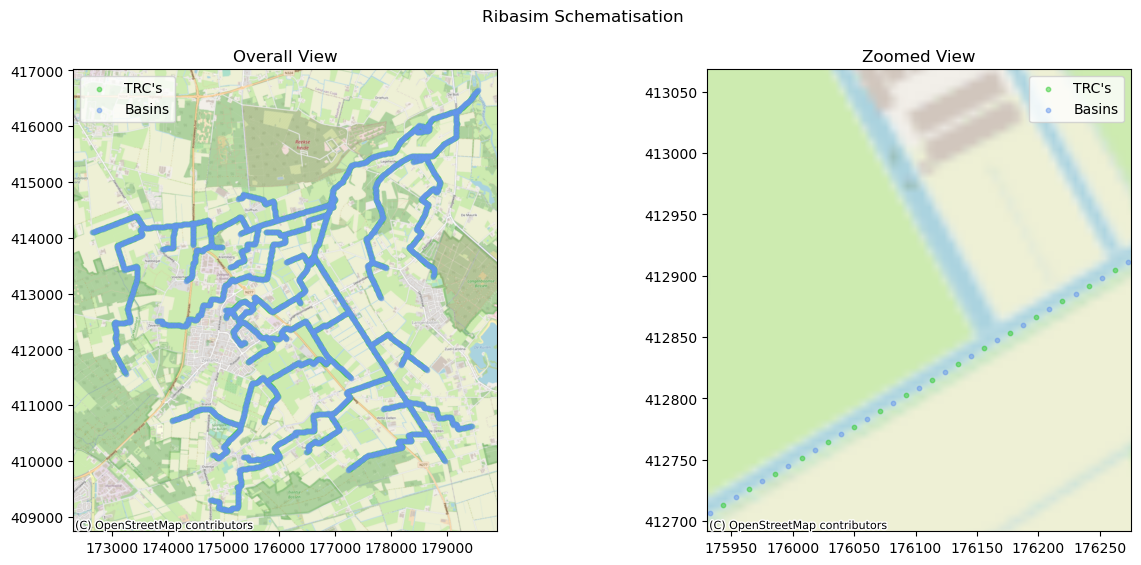

In [6]:
if visualize == True:
    visualizer.plot_basins_TRC_with_zoom(TRC=TRC,
                                         basins = basins,
                                         zoom = 0.025)

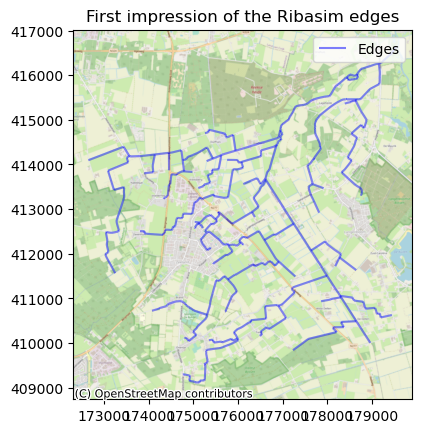

In [7]:
if visualize == True:
    visualizer.plot_edges(edges)

The next step is to add the laterals and boundary data to the network. Depending on the timesteps and number of laterals, this can take up several minutes.

In [8]:
LevelBoundary = network_processor.read_boundary_data(BC_file_path = level_boundary_file_path,
                                                     starttime = starttime,
                                                     unit = 's')
  

FlowBoundary= network_processor.read_boundary_data(BC_file_path = lateral_file_path,
                                                   starttime = starttime,
                                                   unit = 's')

Reading the 9% of the lines
Reading the 18% of the lines
Reading the 27% of the lines
Reading the 36% of the lines
Reading the 45% of the lines
Reading the 55% of the lines
Reading the 64% of the lines
Reading the 73% of the lines
Reading the 82% of the lines
Reading the 91% of the lines
Reading the 100% of the lines
All lines are read

Reading the 10% of the lines
Reading the 20% of the lines
Reading the 30% of the lines
Reading the 40% of the lines
Reading the 50% of the lines
Reading the 60% of the lines
Reading the 70% of the lines
Reading the 80% of the lines
Reading the 90% of the lines
Reading the 100% of the lines
All lines are read



The coordinates of the laterals are located on top of the basins in D-Hydro. In Ribasim we will place them with a certain offset with respect to the adjacing basin, to avoid multiple nodes on the same coordinate. These extra basins should be added. Furthermore, additional edges have to be created to transport water from the boundaries to the assigned basin.

In [11]:
nodes, edges, Flowboundary = network_processor.embed_laterals(his_file_path = his_file_path,
                                                                 edges = edges,
                                                                 nodes = nodes,
                                                                 FlowBoundary = FlowBoundary,
                                                                 offset = 10)

Group the boundary conditions for later use. This is done based on its type (FlowBoundary or LevelBoundary), and whether it is stationairy or non-stationary.

In [12]:
(   flow_boundary_df_static,
    flow_boundary_df_dynamic,
    level_boundary_df_static,
    level_boundary_df_dynamic
) = network_processor.group_boundary_conditions(Flowboundary)

The nodes_id's have been assigned to the laterals and the boundary conditions. They will now be seperated, to easily handle the difference between FlowBoundaries and LevelBoundaries, and stationairy and non-stationary values.

The LevelBoundary may include the terminal node, but if there are multiple LevelBoundaries it is not yet known which acts as the Terminal. This node should be looked up and be stored in the variable Terminal, while changing the type in the nodes variable.

In [13]:
nodes, Terminal = network_processor.find_Terminal(nodes = nodes)

# Create A(h)-relation
Each basin in Ribasim has a profile. It consists of an array with data of the surface area per water level, also known by the A(h)-relation. The Ribasim software calculates the corresponding volumes from this. The surface area for each water level is not a standard output of D-HYDRO. There is however an option to use the VolumeTool, which returns per gridpoint information about the bedlevel, dead storage, volume, and surface area. You are redirected to the D-HYDRO manual for a detailed description of the VolumeTool. For now, following information should be enough to run the VolumeTool on your own device.

Open the command prompt in the folder where the MDU file of D-HYDRO is stored. Insert the location of the bat file  of the VolumeTool, followed by --mdufile [MDU_file name] --increment [increment step size] --output [on which locations you want to get output].

As example, this could be the input in the command prompt:

"c:\Program Files\Deltares\D-HYDRO Suite 2023.02 1D2D\plugins\DeltaShell.Dimr\kernels\x64\dflowfm\scripts\run_dfm_volume_tool.bat" --mdufile DFM.mdu --increment 0.1 --output Gridpoints

Note that at least D-HYDRO version 2023.02 or later is required to succesfully run the VolumeTool. The VolumeTool is also present in older versions, but it does not work correctly. If an older version is used, strange results may arise in the Ribasim schematisation. 

Also note that it may be possible to lose the output of D-HYDRO when running the VolumeTool. It is recommended to create a copy of the model first.

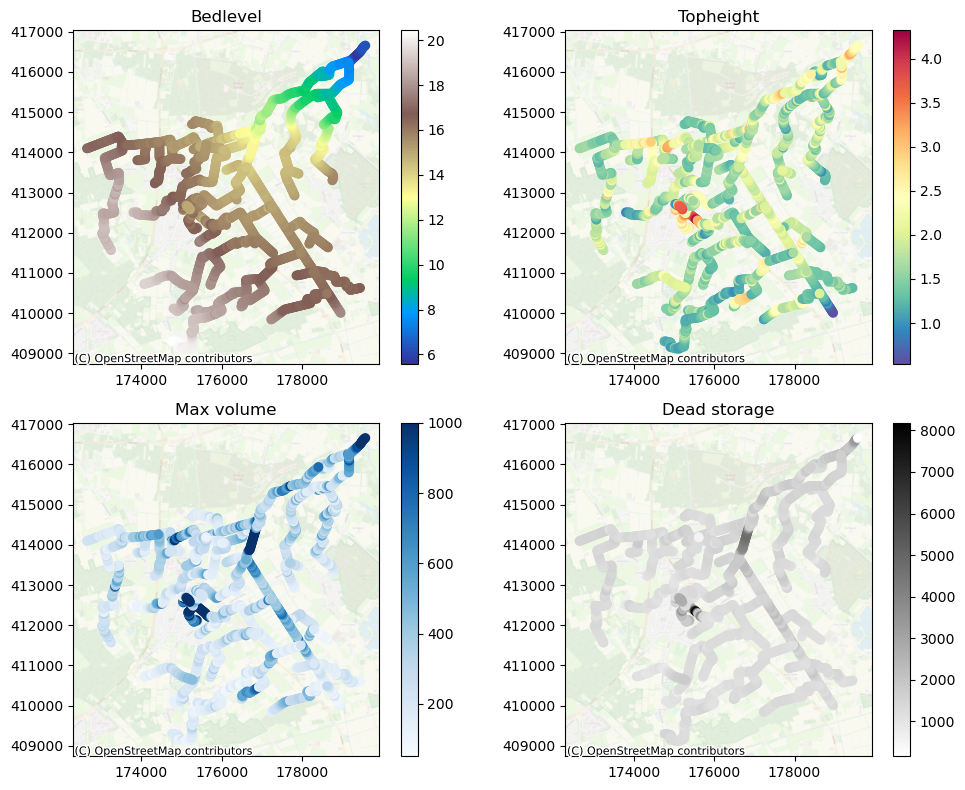

In [14]:
profile_creator = rhydamo.profiles.profile_generator()
VT = profile_creator.load_VolumeTool(VT_path = VT_path)

#plot some basic information of the VolumeTool
#the main goal is to check whether there is unexpected data in the D-HYDRO input
if visualize == True:
    visualizer.VolumeTool_impression(VT=VT)

In [15]:
profiles = profile_creator.create_profile_table(VT=VT,
                                                increment_VT = VT_increment,
                                                basins = basins)

Depending on your input data, the profiles may have to be processed. This can take up till a few minutes, depending on the number of gridpoints.

In [16]:
profiles, removed_indexes = profile_creator.post_process_profile_table(profiles = profiles,
                                                                       basins = basins,
                                                                       terminal = Terminal,
                                                                       fill_value = fill_value)

- Removing non ascending areas and volumes


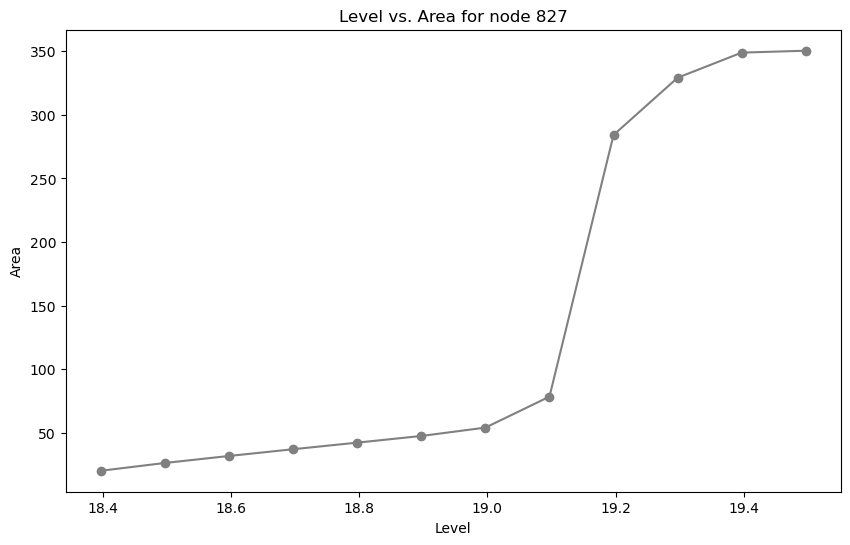

In [17]:
if visualize == True:
    visualizer.profile_sample(profiles = profiles,
                              node_id_of_interest = False)

The initial conditions of Ribasim can be created from the profiles, for example when there should be a water height of i.e. 0.5 meter at each basin at t=0.

In [18]:
IC = profile_creator.create_IC(profiles = profiles, 
                               initial_height = h_ini)

# Create Q(h)-relations
The TabulatedRatingCurves are filled with Q(h)-relations from D-HYDRO. This part is likely to take up the most computation time, which can be a couple minutes, depending on the size of the model and number of simulations.

In [19]:
Qh_relations = rhydamo.Qh.Qh_relations()

Qh = Qh_relations.create_Qh_relations(nc_file_paths = nc_files, 
                                      TRC_basin_relation = TRC_basin_relation, 
                                      n_average_samples = 3)


The Q(h)-relations can not be used straight away. Like the profiles, it needs some post processing:
1) a point where Q == 0
2) non-negative discharges
3) ascending discharges and levels, per node_id

Before doing so, check first if edges are drawn in the wrong direction. It can be chosen to revert the flow direction. However, this should be done with cautious. By doing so, many Terminals may be created automatically. This option is therefore left out as default.

In [20]:
Qh, number_of_negative_flows, edge_nodes = Qh_relations.identify_negative_flow_directions(Qh = Qh, 
                                                                             edge_nodes = edges, 
                                                                             minimum_threshold = minimum_threshold, 
                                                                             revert_line = False)

In [21]:
Qh, removed_indexes, changed_Qh_index = Qh_relations.Qh_post_process(Qh = Qh, 
                                                                       minimum_threshold = minimum_threshold, 
                                                                       fill_value = fill_value)

- Removing too low discharges
- Removing non ascending discharges and levels
- Add extrapolation points to Q = 0


In [22]:
if type(dh_Qh_relation) == int or float:
    Qh, new_manning_nodes, changed_Qh_height = Qh_relations.set_minimum_dt_Qh(Qh = Qh, 
                                                                              changed_Qh_index = changed_Qh_index,
                                                                              dh_Qh_relation = dh_Qh_relation,
                                                                              Terminal = Terminal)
    
    #remove the manning nodes from the TRC to avoid double nodes, and update the nodes itself
    Qh = Qh[~Qh['node_id'].isin(new_manning_nodes['node_id'])]
    nodes.loc[nodes['node_id'].isin(new_manning_nodes['node_id']), 'type'] = 'ManningResistance'

In [23]:
# if visualize == True:
#     visualizer.visualize_changed_Qh(Qh = Qh,
#                                     changed_Qh_index = changed_Qh_index, 
#                                     store_additional_information = store_additional_information)
    
#     visualizer.visualize_elevated_Qh(Qh = Qh,
#                                      changed_Qh_height = changed_Qh_height,
#                                      changed_Qh_index = changed_Qh_index)

A last check on the relation is required since the relations have been changed.

In [24]:
Qh = Qh_relations.last_check_Qh(Qh = Qh, 
                                fill_value = fill_value) 

- Perform the last check on the Qh relations.


# Create Forcing
Use for now dummy = True, as we are using dummy (null) data. This will be updated later on this model generator.

In [25]:
forcing_creator = rhydamo.forcing.forcing_generator()
static_forcing = forcing_creator.create_forcing(basins = basins, 
                                                terminal = Terminal,
                                                dummy = True)

# Create the Ribasim network
Create per table/geometry Ribasim objects

### Set up the nodes

In [26]:
node = ribasim.Node(static = gpd.GeoDataFrame(data={"type": nodes['type']},
                                              geometry=nodes['geometry'],
                                              crs="EPSG:28992").set_index(nodes['node_id']))

### Set up the edges

In [27]:
lines = ribasim.utils.geometry_from_connectivity(node = node, 
                                                 from_id = edges.from_node_id, 
                                                 to_id = edges.to_node_id)

edge = ribasim.Edge(
    static=gpd.GeoDataFrame(
        data={
            "from_node_id": edges.from_node_id,
            "to_node_id": edges.to_node_id,
            "edge_type": edges.edge_type,
        },
        geometry=lines,
        crs="EPSG:28992",
    )
)

### Set up the basins

In [28]:
basin = ribasim.Basin(profile=profiles[['node_id','area', 'level']], 
                      static=static_forcing,
                      forcing = None,
                      state = IC)

### Set up the LevelBoundary

In [29]:
# the level boundary is this time not used as boundary, but as terminal

### Set up the FlowBoundary

In [30]:
flow_boundary_df_dynamic['time_stamp'] = pd.to_datetime(flow_boundary_df_dynamic['time_stamp'])
flow_boundary_df_dynamic['dynamic_value'] = flow_boundary_df_dynamic['dynamic_value'].astype('float64')
flow_boundary_df_dynamic['node_id'] = flow_boundary_df_dynamic['node_id'].astype(int)
flow_boundary_df_dynamic.index+= 1

In [31]:
flow_boundary = ribasim.FlowBoundary(
    static =pd.DataFrame(data= {"node_id": flow_boundary_df_static.node_id,
                                "flow_rate": flow_boundary_df_static.static_value,
                                "active": True,
                                "control_state": 'On'}),

    time =pd.DataFrame(data= {"time": flow_boundary_df_dynamic.time_stamp,
                              "node_id": flow_boundary_df_dynamic.node_id,
                              "flow_rate": flow_boundary_df_dynamic.dynamic_value
                             }))

In [32]:
manning_resistance = ribasim.ManningResistance(
    static=pd.DataFrame(
        data={
            "node_id": list(new_manning_nodes.node_id.unique()),
            "length": 30.0,
            "manning_n": 0.04,
            "profile_width": 4.0,
            "profile_slope": 3.0,
        }
    )
)

### Set up the TabulatedRatingCurve

In [33]:
rating_curve = ribasim.TabulatedRatingCurve(
    static=pd.DataFrame(
        data={
            "node_id": Qh.node_id,
            "level": Qh.level,
            "discharge": Qh.discharge,
        }
    )
)

### Set up the Terminal

In [34]:
terminal = ribasim.Terminal(
    static=pd.DataFrame(
        data={
            "node_id": [Terminal.node_id.values[0]],
        }
    )
)

### Set up the Model

In [35]:
#Setup a model
model = ribasim.Model(
    modelname=model_name,
    node=node,
    edge=edge,
    basin=basin,
    # level_boundary=level_boundary,
    flow_boundary=flow_boundary,
    # pump=pump,
    # linear_resistance=linear_resistance,
    manning_resistance=manning_resistance,
    tabulated_rating_curve=rating_curve,
    # fractional_flow=fractional_flow,
    terminal=terminal,
    starttime=starttime,
    endtime=endtime,
)

In [36]:
if not os.path.exists('Results\Models'):
   os.makedirs('Results\Models')

path = r'Results\Models'
path = os.path.join(path, '', model_name)
model.write(path)

C:\Users\Bruijns\Anaconda3\envs\TKI_Ribasim\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [21]:
basin_path_Qh = r"D:\Users\Bruijns\Documents\TKI Ribasim\TKI-ribasim\Results\Models\20231030_tweede\output\basin.arrow"
basin_arrow_Qh = load_results(path = basin_path_Qh,
                           resample_frequency = 'T',
                           aggregation_method = 'mean',
                           interpolate = True)

basin_arrow_Manning_path = r"D:\Users\Bruijns\Documents\TKI Ribasim\TKI-ribasim\Results\Models\20231030_tweede\output\basin.arrow"
basin_arrow_Manning = load_results(path = basin_arrow_Manning_path,
                           resample_frequency = 'T',
                           aggregation_method = 'mean',
                           interpolate = True)

In [37]:
#DHYDRO
results_path =r"D:\Users\Bruijns\Documents\TKI Ribasim\Modellen\HogeRaamDynamisch\Resultaten_positieve_t_lateralen_10_dagen\Project1.dsproj_data\DFM\output\DFM_map.nc"
results = xr.open_dataset(results_path)

#Ribasim
#define water levels
h_DHYDRO = results.mesh1d_s1
h_DHYDRO = h_DHYDRO.dropna(dim='time') #avoid empty data
h_Ribasim_Qh = basin_arrow_Qh
h_Ribasim_Manning = basin_arrow_Manning

In [38]:
def post_process_h_results(basin_overview, h_DHYDRO, h_Ribasim):
    """
    Post-processes water level data from D-HYDRO and Ribasim simulations.

    This function takes water level data from D-HYDRO and Ribasim simulations,
    along with basin overview information, and performs necessary post-processing
    to format and organize the data for comparison.

    Parameters:
        basin_overview (geopandas.GeoDataFrame): A GeoDataFrame containing basin overview
            information including node IDs and geometries.
        h_DHYDRO (xarray.Dataset): Water level data from D-HYDRO simulation.
        h_Ribasim (pd.DataFrame): Water level data from Ribasim simulation.

    Returns:
        tuple: A tuple containing two dataframes:
            - h_Ribasim (pd.DataFrame): Post-processed Ribasim water level data.
            - h_DHYDRO (pd.DataFrame): Post-processed D-HYDRO water level data.
    """
        
    h_coords = gpd.GeoDataFrame(geometry = gpd.points_from_xy(results.mesh1d_s1.coords['mesh1d_node_x'], results.mesh1d_s1.coords['mesh1d_node_y']))
    find_basins = h_coords.merge(basin_overview, on='geometry')[['geometry', 'node_id']]
    
    #post process the data format of the water level of D-HYDRO
    h_DHYDRO = results.mesh1d_s1
    h_DHYDRO = h_DHYDRO.to_dataframe()
    h_DHYDRO.sort_values(by=['mesh1d_nNodes', 'time'], inplace = True)
    geometry = gpd.GeoDataFrame(geometry = gpd.points_from_xy(h_DHYDRO['mesh1d_node_x'].iloc[:], h_DHYDRO['mesh1d_node_y'].iloc[:]))

    geometry.set_index(h_DHYDRO.index, inplace=True) # Set the index of the geometry GeoDataFrame to match the MultiIndex of h_DHYDRO
    h_DHYDRO['geometry'] = geometry

    #rename and filter columns        
    h_DHYDRO.rename(columns={'mesh1d_s1': 'level_DHYDRO'}, inplace=True) #change names for better comparison
    h_DHYDRO.index.set_names({'mesh1d_nNodes': 'node_id'}, inplace = True)
    h_DHYDRO = h_DHYDRO[['level_DHYDRO', 'geometry']]
    h_DHYDRO = h_DHYDRO.reset_index(level=[0,1])
    h_DHYDRO.node_id += 1
    
    #post process the data format of the water level of Ribasim
    if 'node_id' in h_Ribasim.columns:
        h_Ribasim.drop('node_id', axis=1, inplace=True)
    h_Ribasim = h_Ribasim.reset_index(level=[0,1])
    h_Ribasim = h_Ribasim.merge(basin_overview, left_on =h_Ribasim['node_id'], right_on='node_id')[['node_id', 'time', 'storage', 'level', 'geometry']]
    h_Ribasim.rename(columns={'level': 'level_Ribasim'}, inplace = True)
    h_Ribasim.sort_values(by=['node_id', 'time'])

    return h_Ribasim, h_DHYDRO


In [39]:
h_Ribasim_Qh, h_DHYDRO = post_process_h_results(basin_overview = basins, 
                                             h_DHYDRO = h_DHYDRO, 
                                             h_Ribasim = h_Ribasim_Qh)


In [40]:
# h_Ribasim_Qh.time -= timedelta(1) 
h_Ribasim_Qh = h_Ribasim_Qh.loc[h_Ribasim_Qh.time < "2010-11-20 00:00:01"] 
# h_DHYDRO = h_DHYDRO.loc[h_DHYDRO.time > '2010-11-10 12:00:00'] 

In [46]:
node_id_oi = 2583

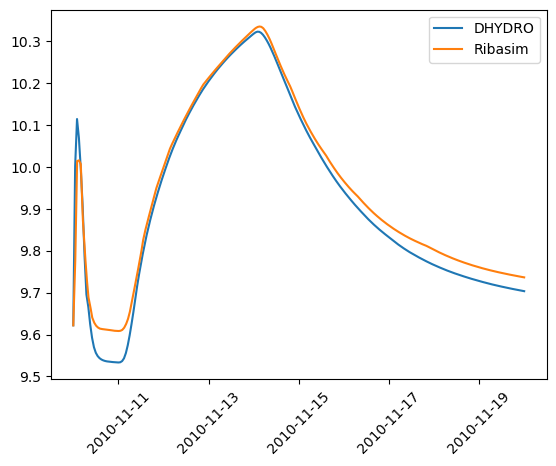

In [47]:
plt.plot(h_DHYDRO.loc[h_DHYDRO.node_id == node_id_oi].time,
        h_DHYDRO.loc[h_DHYDRO.node_id == node_id_oi].level_DHYDRO,
        label = 'DHYDRO')

plt.plot(h_Ribasim_Qh.loc[h_Ribasim_Qh.node_id == node_id_oi].time,
        h_Ribasim_Qh.loc[h_Ribasim_Qh.node_id == node_id_oi].level_Ribasim,
        label = 'Ribasim')
plt.xticks(rotation = 45)
# plt.xlim(datetime(2010, 11, 10), datetime(2010, 11, 12))
plt.legend()

In [27]:
h_Ribasim_Manning, h_DHYDRO = post_process_h_results(basin_overview = basins, 
                                             h_DHYDRO = h_DHYDRO, 
                                             h_Ribasim = h_Ribasim_Manning)


In [28]:
def equalize_time(h_Ribasim, h_DHYDRO, n_hours, offset = 0):
    
    """
    Equalizes and aligns time intervals between Ribasim and D-HYDRO water level data.

    This function takes water level data from Ribasim and D-HYDRO simulations, along with
    specified parameters for time interval equalization, and adjusts the data to have the
    same time range and alignment.

    Parameters:
        h_Ribasim (pd.DataFrame): Water level data from Ribasim simulation.
        h_DHYDRO (pd.DataFrame): Water level data from D-HYDRO simulation.
        n_hours (int): Number of hours for the target time interval.

    Returns:
        tuple: A tuple containing two dataframes:
            - h_Ribasim (pd.DataFrame): Ribasim water level data within the specified time range.
            - h_DHYDRO (pd.DataFrame): D-HYDRO water level data within the specified time range,
              aligned with Ribasim data.
    """
    #Ribasim
    start_date_R = h_Ribasim.time.iloc[0]
    end_date_R = start_date_R + timedelta(hours=n_hours) 
    h_Ribasim = h_Ribasim[(h_Ribasim['time'] >= start_date_R) & (h_Ribasim['time'] <= end_date_R)]
    
    #D-HYDRO
    start_date_D = h_DHYDRO.time.iloc[0]
    end_date_D = start_date_D + timedelta(hours=n_hours)  
    h_DHYDRO = h_DHYDRO[(h_DHYDRO['time'] >= start_date_D) & (h_DHYDRO['time'] <= end_date_D)]
    
    #align time
    time_diff = start_date_R - h_DHYDRO['time'].iloc[0]
    h_DHYDRO['time'] = h_DHYDRO['time'] + time_diff + timedelta(offset)
    
    return h_Ribasim, h_DHYDRO
    
h_Ribasim_Qh_eq, h_DHYDRO_eq = equalize_time(h_Ribasim = h_Ribasim_Qh, 
                                  h_DHYDRO = h_DHYDRO, 
                                  n_hours = 12*24,
                                  offset = 0) #one day offset

h_Ribasim_Manning_eq, h_DHYDRO_eq = equalize_time(h_Ribasim = h_Ribasim_Manning, 
                                  h_DHYDRO = h_DHYDRO, 
                                  n_hours = 12*24,
                                  offset = 0)

In [29]:
if 'h_Ribasim_Qh' in locals():
    del h_Ribasim_Qh
    del h_Ribasim_Manning
    del h_DHYDRO
    
h_Ribasim_Qh_eq.time = h_Ribasim_Qh_eq.time.astype(str)
h_Ribasim_Manning_eq.time = h_Ribasim_Manning_eq.time.astype(str)
h_DHYDRO_eq.time = h_DHYDRO_eq.time.astype(str)

h_Ribasim_Qh_eq = h_Ribasim_Qh_eq[h_Ribasim_Qh_eq['time'].str.endswith('00:00')]
h_Ribasim_Manning_eq = h_Ribasim_Manning_eq[h_Ribasim_Manning_eq['time'].str.endswith('00:00')]
h_DHYDRO_eq = h_DHYDRO_eq[h_DHYDRO_eq['time'].str.endswith('00:00')]

h_Ribasim_Qh_eq['time'] = pd.to_datetime(h_Ribasim_Qh_eq['time'])
h_Ribasim_Manning_eq['time'] = pd.to_datetime(h_Ribasim_Manning_eq['time'])
h_DHYDRO_eq['time'] = pd.to_datetime(h_DHYDRO_eq['time'])


In [30]:
h_Ribasim_Qh_eq.reset_index(inplace = True, drop = True)
h_Ribasim_Manning_eq.reset_index(inplace = True, drop = True)
h_DHYDRO_eq.reset_index(inplace = True, drop = True)

<Axes: >

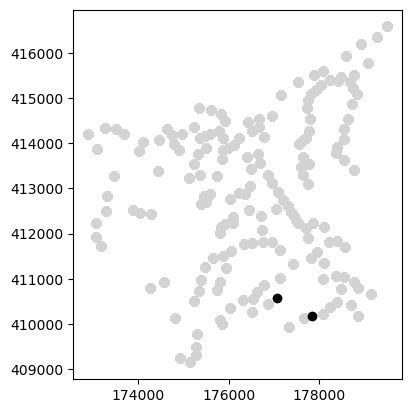

In [31]:
fig, ax = plt.subplots()

gpd.GeoDataFrame(flow_boundary_df_dynamic).plot(ax = ax, c = 'lightgray', alpha = 0.9)
gpd.GeoDataFrame(flow_boundary_df_static).plot(ax = ax, c = 'black')

In [52]:
h_DHYDRO_eq = h_DHYDRO_eq.loc[h_DHYDRO_eq.time > '2010-11-10 12:00:00'] 

In [32]:
def plot_levels_three(h_Ribasim_Qh, h_Ribasim_Manning, h_DHYDRO, node_id_of_interest, alterated_Qh, new_manning_nodes):
    """
    Plot water level data for a specific node ID from Ribasim and D-HYDRO simulations.

    This function takes Ribasim and D-HYDRO water level data, along with a specified node ID,
    and creates a comparison plot of water levels over time for the given node ID.

    Parameters:
        h_Ribasim (pd.DataFrame): Ribasim water level data.
        h_DHYDRO (pd.DataFrame): D-HYDRO water level data.
        node_id_of_interest (int): Node ID for which to plot water levels.

    Returns:
        None (displays a plot): A plot comparing water levels over time for the specified node ID.
    """
    
    # Filter data for the specified node_id
    h_Ribasim_Qh_node = h_Ribasim_Qh[h_Ribasim_Qh['node_id'] == node_id_of_interest]
    h_Ribasim_Manning_node = h_Ribasim_Manning[h_Ribasim_Manning['node_id'] == node_id_of_interest]
    h_DHYDRO_node = h_DHYDRO[h_DHYDRO['node_id'] == node_id_of_interest]
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(h_Ribasim_Qh_node['time'], h_Ribasim_Qh_node['level_Ribasim'], label='h_Ribasim_Manning_and_dt_10cm', c = 'black')
    # plt.plot(h_Ribasim_Qh_node.index, h_Ribasim_Qh_node['level_Ribasim'], label='h_Ribasim_Manning_and_dt_10cm', c = 'black')
    # plt.plot(h_Ribasim_Manning_node['time'], h_Ribasim_Manning_node['level_Ribasim'], label='h_Ribasim_all_Manning', c = 'gray')
    # plt.plot(h_Ribasim_Manning_node.index, h_Ribasim_Manning_node['level_Ribasim'], label='h_Ribasim_all_Manning', c = 'gray')
    plt.plot(h_DHYDRO_node['time'], h_DHYDRO_node['level_DHYDRO'], label='h_DHYDRO', c = 'cornflowerblue')
    # plt.plot(h_DHYDRO_node.index, h_DHYDRO_node['level_DHYDRO'], label='h_DHYDRO', c = 'cornflowerblue')
    plt.xlabel('Time')
    plt.ylabel('Level')
    plt.title(f'Water Level Comparison for basin/node {node_id_of_interest}')
    plt.legend()
    plt.show()
    
    #plot map
    network = h_Ribasim_Qh.drop_duplicates(subset = 'node_id')
    NoI = h_Ribasim_Qh_node.iloc[0:1, :]
    network = gpd.GeoDataFrame(network, geometry = 'geometry')
    NoI = gpd.GeoDataFrame(NoI, geometry = 'geometry')
    
    fig, ax = plt.subplots()
    network.plot(ax = ax, color = 'cornflowerblue', markersize = .5, label = 'Network')
    new_manning_nodes.plot(ax=ax, color = 'orange', alpha = .5, markersize = 1, label = 'Manning resistance')
    # alterated_Qh.plot(ax=ax, color = 'red', alpha = .5, markersize = 1, label = 'Dummy Qh relations')
    NoI.plot(ax = ax, color = 'black', label = 'Node of Interest')
    ctx.add_basemap(ax, crs='EPSG:28992',source=ctx.providers.OpenStreetMap.Mapnik)
    plt.title(f'Location of node {node_id_of_interest}')
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))    

    if not os.path.exists('Results\Interim_results'):
       os.makedirs('Results\Interim_results')
    filename = 'Results/Interim_results/Locations of the adapted Qh relations new.png'
    plt.savefig(filename, bbox_inches='tight')
    plt.show()


plot_levels_three(h_Ribasim_Qh = h_Ribasim_Qh_eq,
                  h_Ribasim_Manning = h_Ribasim_Manning_eq,
                  h_DHYDRO = h_DHYDRO_eq, 
                  node_id_of_interest = 2516,
                  alterated_Qh = nodes.loc[nodes.node_id.isin(changed_Qh_index)],
                  new_manning_nodes = new_manning_nodes)


NameError: name 'changed_Qh_index' is not defined

In [ ]:
h_Ribasim_eq = h_Ribasim_Qh_eq
for i in range(6):

    time_of_interest = f'2011-11-11 {i}:00:00'
    #merge the results of DHYDRO and Ribasim
    merged_df = pd.merge(h_Ribasim_eq, h_DHYDRO_eq, on=['time', 'node_id'], how='left', suffixes=('_Ribasim', '_DHYDRO')).dropna()
    merged_df['level_difference'] = merged_df['level_DHYDRO'] - merged_df['level_Ribasim'] # Calculate the difference between levels
    merged_df = gpd.GeoDataFrame(merged_df, geometry = merged_df['geometry_DHYDRO'])
    merged_df = merged_df.loc[merged_df.time == time_of_interest]

    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title(f"Level differences on {time_of_interest} \n (D-HYDRO - Ribasim_Manning)")
    sc = merged_df.plot(ax=ax, marker='o', column='level_difference', cmap='coolwarm', markersize=50, legend=True, vmin=-1, vmax=1)
    ctx.add_basemap(ax, crs='EPSG:28992',source=ctx.providers.OpenStreetMap.Mapnik, alpha = 0.35)

    # Show the plot
    plt.show()

In [ ]:
merged_df = pd.merge(h_Ribasim_Qh_eq, h_DHYDRO_eq, on=['time', 'node_id'], how='left', suffixes=('_Ribasim', '_DHYDRO')).dropna()
merged_df['level_difference'] = merged_df['level_DHYDRO'] - merged_df['level_Ribasim'] # Calculate the difference between levels
merged_df = gpd.GeoDataFrame(merged_df, geometry = merged_df['geometry_DHYDRO'])

In [ ]:
max_merged_df = gpd.GeoDataFrame(merged_df, geometry = 'geometry')
max_merged_df['abs_level_difference'] = abs(max_merged_df['level_difference'])
max_merged_df.sort_values(by = ['node_id', 'abs_level_difference'], inplace = True, ascending = False)
max_merged_df.drop_duplicates(subset = 'node_id', keep = 'first', inplace = True)
max_merged_df.drop(columns=['time', 'geometry_Ribasim', 'geometry_DHYDRO'], inplace = True)
max_merged_df.to_file('Results/Interim_results/Max_diff.shp', crs = 'EPSG:28992')


In [ ]:
time_of_interest = '2010-11-15 06:00:00'
diff_at_peak = merged_df.loc[merged_df.time == time_of_interest]
diff_at_peak.drop(columns=['time', 'geometry_Ribasim', 'geometry_DHYDRO'], inplace = True)
diff_at_peak.to_file('Results/Interim_results/Diff_at_peak.shp', crs = 'EPSG:28992')


In [ ]:
def plot_cumsum(path_DHYDRO, path_ribasim, node_id_dhydro, node_id_ribasim):
    #load in D-HYDRO Q
    Q_dhy = xr.open_dataset(path_DHYDRO)['mesh1d_q1']
    Q_dhy = Q_dhy[:, node_id_dhydro]
    Q_dhy = pd.DataFrame(Q_dhy)
    Q_dhy['time'] = xr.open_dataset(path_DHYDRO)['mesh1d_q1']['time']
    Q_dhy['time'] = pd.to_datetime(Q_dhy['time'])
    # Q_dhy.time += timedelta(366.25)
    # Q_dhy.time += timedelta(365)
    Q_dhy['Q'] = Q_dhy.loc[:,0]
    # Q_dhy = Q_dhy.loc[Q_dhy.time > '2010-11-10 12:00:00']
    Q_dhy.set_index('time', inplace = True)
    # display(Q_dhy)
    
    #Load in Ribasim Q
    Q_table = ft.read_table(path_ribasim)
    Q_riba = Q_table.to_pandas()    
    Q_riba = Q_riba.loc[Q_riba.to_node_id == node_id_ribasim]
    Q_riba['time'] = pd.to_datetime(Q_riba['time'])
    Q_riba = Q_riba.loc[Q_riba.time < "2010-11-20 00:00:01"]
    
    # Q_riba.time -= timedelta(1) 
    # Q_riba = Q_riba.loc[Q_riba.time > '2010-11-10 12:00:00']
    # Q_riba = Q_riba.loc[Q_riba.time <= '2011-11-21 00:00:01']
    Q_riba.set_index('time', inplace = True)
    # display(Q_riba)
    
    #calculate cumsum
    Q_dhy['Q_cumsum'] = Q_dhy.Q.cumsum()
    Q_riba['Q_cumsum'] = Q_riba.flow.cumsum()
    
    
    #plot cumsum
    # display(Q_riba)
    plt.plot(Q_dhy.Q_cumsum, label = 'D-HYDRO')
    plt.plot(Q_riba.Q_cumsum, label = 'Ribasim')
    plt.title('Cumulative discharge at the most downstream node')
    plt.ylabel('Cumulative discharge [m3]')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show();


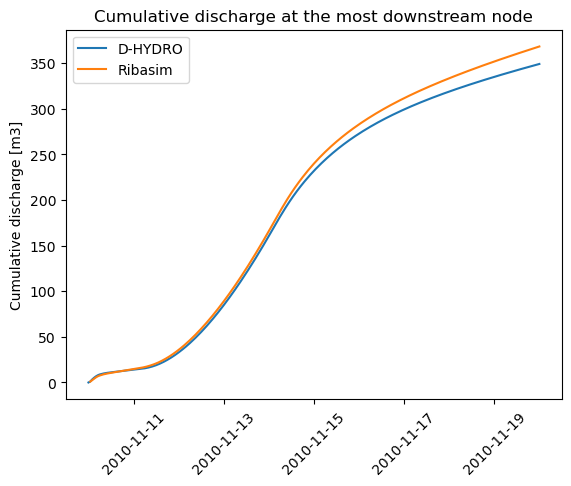

In [18]:
# path_ribasim = r"D:\Users\Bruijns\Documents\TKI Ribasim\TKI-ribasim\Results\Models\20231026\output\flow.arrow"
# path_DHYDRO = r"D:\Users\Bruijns\Documents\TKI Ribasim\Modellen\HogeRaamDynamisch\Hoogwater3\Opnieuw\FM_model.dsproj_data\DFM\output\DFM_map.nc"
path_DHYDRO = r"D:\Users\Bruijns\Documents\TKI Ribasim\Modellen\HogeRaamDynamisch\Resultaten_positieve_t_lateralen_10_dagen\Project1.dsproj_data\DFM\output\DFM_map.nc"
path_ribasim = r"D:\Users\Bruijns\Documents\TKI Ribasim\TKI-ribasim\Results\Models\20231030_tweede\output\flow.arrow"
node_id_dhydro =  2206
node_id_ribasim = 2214

plot_cumsum(path_DHYDRO = path_DHYDRO, 
            path_ribasim = path_ribasim, 
            node_id_dhydro = node_id_dhydro,
            node_id_ribasim = node_id_ribasim)

In [11]:
list(xr.open_dataset(path_DHYDRO).keys())

['projected_coordinate_system',
 'network',
 'network_edge_nodes',
 'network_branch_id',
 'network_branch_long_name',
 'network_edge_length',
 'network_node_id',
 'network_node_long_name',
 'network_node_x',
 'network_node_y',
 'network_geometry',
 'network_geom_node_count',
 'network_geom_x',
 'network_geom_y',
 'network_branch_order',
 'network_branch_type',
 'mesh1d',
 'mesh1d_node_branch',
 'mesh1d_node_offset',
 'mesh1d_edge_branch',
 'mesh1d_edge_offset',
 'mesh1d_node_id',
 'mesh1d_node_long_name',
 'mesh1d_edge_nodes',
 'mesh1d_FlowElemContour_x',
 'mesh1d_FlowElemContour_y',
 'mesh1d_flowelem_ba',
 'mesh1d_flowelem_bl',
 'timestep',
 'mesh1d_Numlimdt',
 'mesh1d_s1',
 'mesh1d_s0',
 'mesh1d_waterdepth',
 'mesh1d_u1',
 'mesh1d_u0',
 'mesh1d_ucx',
 'mesh1d_ucy',
 'mesh1d_ucmag',
 'mesh1d_q1',
 'mesh1d_viu',
 'mesh1d_diu',
 'mesh1d_tausx',
 'mesh1d_tausy',
 'mesh1d_taus',
 'mesh1d_czs']

In [58]:
# Q_dhy = xr.open_dataset(r"D:\Users\Bruijns\Documents\TKI Ribasim\Modellen\HogeRaamDynamisch\Hoogwater3\Opnieuw\FM_model.dsproj_data\DFM\output\DFM_map.nc")['mesh1d_q1']
# values = Q_dhy.mesh1d_edge_y.values
# sorted_indices = np.argsort(values)[::-1]
# second_highest_index = sorted_indices[1]
# print("Index of the second highest value:", second_highest_index)

Index of the second highest value: 2206


In [61]:
Q_dhy['Q_cumsum'] = Q_dhy.Q.cumsum()
Q_riba['Q_cumsum'] = Q_riba.flow.cumsum()

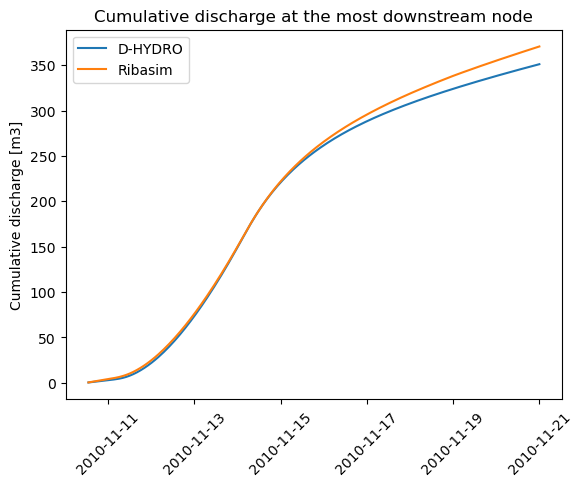

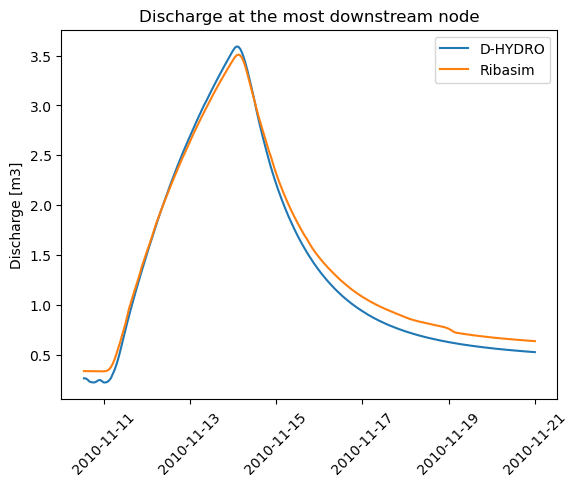

In [63]:
# fig, ax = plt.subplots()
plt.plot(Q_dhy.Q, label = 'D-HYDRO')
plt.plot(Q_riba.flow, label = 'Ribasim')
plt.title('Discharge at the most downstream node')
plt.ylabel('Discharge [m3]')
plt.legend()
plt.xticks(rotation=45);


In [64]:
display(Q_riba.tail())
display(Q_dhy.tail())

,edge_id,from_node_id,to_node_id,flow,Q_cumsum
time,,,,,
2010-11-20 20:00:00,4593,4797,2214,0.639742,368.118857
2010-11-20 21:00:00,4593,4797,2214,0.638516,368.757373
2010-11-20 22:00:00,4593,4797,2214,0.637238,369.394611
2010-11-20 23:00:00,4593,4797,2214,0.636045,370.030656
2010-11-21 00:00:00,4593,4797,2214,0.634789,370.665445


,0,Q,Q_cumsum
time,,,
2010-11-20 20:00:00,0.529500,0.529500,349.030310
2010-11-20 21:00:00,0.528128,0.528128,349.558438
2010-11-20 22:00:00,0.526764,0.526764,350.085202
2010-11-20 23:00:00,0.525421,0.525421,350.610623
2010-11-21 00:00:00,0.524112,0.524112,351.134734


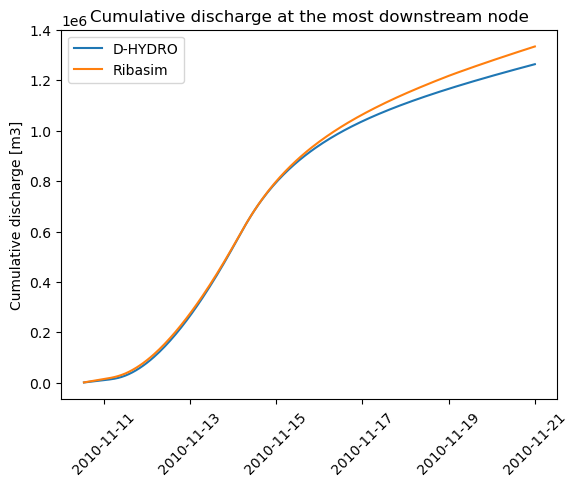

In [65]:
# fig, ax = plt.subplots()
plt.plot(Q_dhy.Q_cumsum*3600, label = 'D-HYDRO')
plt.plot(Q_riba.Q_cumsum*3600, label = 'Ribasim')
plt.title('Cumulative discharge at the most downstream node')
plt.ylabel('Cumulative discharge [m3]')
plt.legend()
plt.xticks(rotation=45);


In [66]:
# h_Ribasim_eq = h_Ribasim_Manning_eq
# for i in range(12):

#     time_of_interest = f'2011-11-10 {i}:00:00'
#     #merge the results of DHYDRO and Ribasim
#     merged_df = pd.merge(h_Ribasim_eq, h_DHYDRO_eq, on=['time', 'node_id'], how='left', suffixes=('_Ribasim', '_DHYDRO'))
#     merged_df['level_difference'] = merged_df['level_DHYDRO'] - merged_df['level_Ribasim'] # Calculate the difference between levels
#     merged_df = gpd.GeoDataFrame(merged_df, geometry = merged_df['geometry_DHYDRO'])
#     merged_df = merged_df.loc[merged_df.time == time_of_interest]

#     # Create a plot
#     fig, ax = plt.subplots(figsize=(10, 8))
#     ax.set_title(f"Level differences on {time_of_interest} \n (D-HYDRO - Ribasim_Manning)")
#     sc = merged_df.plot(ax=ax, marker='o', column='level_difference', cmap='coolwarm', markersize=50, legend=True, vmin=-3, vmax=3)
#     ctx.add_basemap(ax, crs='EPSG:28992',source=ctx.providers.OpenStreetMap.Mapnik, alpha = 0.35)

#     # Show the plot
#     plt.show()

In [67]:
#write basic profile information
max_level = profiles.drop_duplicates(subset='node_id', keep='last')
max_level = max_level.merge(nodes, on='node_id', how='inner')
max_level = gpd.GeoDataFrame(max_level, geometry='geometry')
max_level.to_file('Results/Interim_results/max_profiles.shp', crs='EPSG:28992')

C:\Users\Bruijns\Anaconda3\envs\TKI_Ribasim\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
